## Python Notebook to compare Xavier Initialisation to Constant Variance Initialisation

This notebook presents a comparison of Xavier initialisation to Constant Variance initialisation, focusing on S-shaped activation functions including Tanh, Sigmoid and Softsign.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets

from torch import nn


import torchvision

from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from PIL import Image, ImageDraw, ImageFont

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import platform

C:\Users\rmen2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def XavierInitialisation(network):
    """ Perform Xavier Initialisation on a Neural Network """
    for p in network.modules():
        if p.__class__.__name__ == "Linear" or p.__class__.__name__ == "Conv2d":
            with torch.no_grad():
                nn.init.xavier_uniform_(p.weight)

# All the coefficients for maintaining a constant variance propagation
normalising_coeff_dict = {
    #nn.Sigmoid: 1.92,
    nn.Tanh: 1.58,
    nn.ReLU: 1.41,
    #nn.Softsign: 2.317374,
    #nn.ELU: 1.242043
}

normalising_coeff_arr = normalising_coeff_dict.values()


activation_functions = [
    nn.ReLU,
    nn.Tanh,
    nn.Sigmoid,
    nn.SELU,
    nn.GELU
]

def ConstVarInitialisation(network, normalising_coefficient=None, normal=True):
    """ Perform Constant Variance Initialisation on a Neural Network """
    net_modules = list(network.modules())
    for i, p in enumerate(network.modules()):
        if p.__class__.__name__ == "Linear" or p.__class__.__name__ == "Conv2d" and normalising_coefficient is not None:
            with torch.no_grad():
                receptive_field_size = 1
                if p.weight.dim() > 2:
                    for s in p.weight.shape[2:]:
                        receptive_field_size *= s
                if normalising_coefficient is None:
                    # Get what the coefficient should be by looking at the applied activation before this layer
                    normalising_coefficient = normalising_coeff_dict[net_modules[i - 1].__class__]
                if normal:
                    p.weight.normal_(0, normalising_coefficient / np.sqrt(p.weight.shape[1]*receptive_field_size))
                else:
                    p.weight.uniform_(
                        -normalising_coefficient / np.sqrt(p.weight.shape[1]*receptive_field_size),
                        normalising_coefficient / np.sqrt(p.weight.shape[1]*receptive_field_size)
                    )
                # Fill bias with zeros
                p.bias.zero_()

def test_backpropagation(neural_network, data_loader, loss_fn):
    """ Get the backpropagation distributions from running a number of inputs to the network """
    handles = []
    layerID = 0
    backpropagation_values = {}
    # Set hooks
    def set_backward_hooks(name):
        def hook(model, input, output):
            backpropagation_values[name].append(output[0].detach())
        return hook

    # Initialise hook storage holders
    for m in neural_network.modules():
        #print(m.__class__.__name__)
        if m.__class__.__name__ == "Linear" or m.__class__.__name__ == "Conv2d":
            handles.append(m.register_full_backward_hook(set_backward_hooks(layerID)))
            backpropagation_values[layerID] = []
            layerID+=1

    # Run a few inputs through the network and measure backpropagation with hooks
    for batch, (X, y) in enumerate(data_loader):
        pred = neural_network(X)
        loss = loss_fn(pred, y)

        loss.backward()
        if batch > 20:
            break

    # Remove hooks
    for h in handles:
        h.remove()

    return backpropagation_values



def test_backpropagation_scaled(neural_network, data_loader, loss_fn):
    """ Get the backpropagation distributions from running a number of inputs to the network """
    handles = []
    layerID = 0
    backpropagation_values = {}
    # Set hooks
    def set_backward_hooks(name):
        def hook(model, input, output):
            backpropagation_values[name].append(output[0].detach())
        return hook

    # Initialise hook storage holders
    for m in neural_network.modules():
        if m.__class__.__name__ == "Linear":
            handles.append(m.register_full_backward_hook(set_backward_hooks(layerID)))
            backpropagation_values[layerID] = []
            layerID+=1

    # Run a few inputs through the network and measure backpropagation with hooks
    for batch, (X, y) in enumerate(data_loader):
        # Compute how to scale the backpropagation to ensure it is constant variance the backpropagation which ensures
        pred = neural_network(X)
        loss = loss_fn(pred, y)

        loss.backward()

        # Get the variance of the gradient of the 2nd last module (layer before output layer), then mimic that over all layers
        print(neural_network.modules())
        propagated_var = np.var(neural_network.modules()[-2].grad)
        backpropagation_values.append(neural_network.modules()[0])
        for i, m in enumerate(neural_network.modules()[1:]):
            m.grad *= propagated_var/m.grad
            backpropagation_values.append(m.grad)

        if batch > 20:
            break

    # Remove hooks
    for h in handles:
        h.remove()

    return backpropagation_values



In [3]:
def test_forward_propagation(neural_network, data, loss_fn):
    # Handles for the layer hooks
    handles = []

    # Register a forward hook to get the value of each layer
    layer_intermediate_values = {}
    def set_forward_hooks(name):
        def hook(model, input, output):
            layer_intermediate_values[name] = output.detach()
        return hook

    layerID = 0
    for m in neural_network.modules():
        if m.__class__.__name__ == "Linear" or m.__class__.__name__ == "Conv2d":
            handles.append(m.register_forward_hook(set_forward_hooks(layerID)))
            layerID += 1

    # Need to run network to get intermediate values
    _out = neural_network(torch.stack([data[d][0] for d in range(1000)]))

    # Remove all handles
    for h in handles:
        h.remove()

    del handles
    del _out

    # Return the intermediate values in the layers
    return layer_intermediate_values

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

activation_function = nn.Tanh()

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = activation_function(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = activation_function(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = activation_function(self.bn1(self.conv1(x)))
        out = activation_function(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = activation_function(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = activation_function(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [5]:

class NNFashionMNISTBackpropTest(nn.Module):
    """ Neural network for use with the FashionMNIST dataset """
    def __init__(self, activation_function):
        super(NNFashionMNISTBackpropTest, self).__init__()
        # Use standard Neural Network architecture, this is not a study
        # of the best architecture to use for this dataset.
        self.module_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            activation_function(),
            nn.Linear(1024, 1024),
            activation_function(),
            nn.Linear(1024, 512),
            activation_function(),
            nn.Linear(512, 512),
            activation_function(),
            nn.Linear(512, 512),
            activation_function(),
            nn.Linear(512, 512),
            activation_function(),
            nn.Linear(512, 256),
            activation_function(),
            nn.Linear(256, 256),
            activation_function(),
            nn.Linear(256, 256),
            activation_function(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.module_stack(x)

class NNFashionMNIST(nn.Module):
    """ Neural network for use with the FashionMNIST dataset """
    def __init__(self, activation_function):
        super(NNFashionMNIST, self).__init__()
        # Use standard Neural Network architecture, this is not a study
        # of the best architecture to use for this dataset.
        self.module_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            activation_function(),
            nn.Linear(100, 32),
            activation_function(),
            nn.Linear(32, 28),
            activation_function(),
            nn.Linear(28, 10),
            nn.Softmax(dim=0)
        )

    def forward(self, x):
        return self.module_stack(x)


def NNLayerTest(num_layers):
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Linear(28*28, 1024))
    for _ in range(num_layers):
        layers.append(nn.Linear(1024, 1024))
        layers.append(torch.nn.ReLU)

    layers.append(nn.Linear(1024, 10))

    class NNFashionMNISTBackpropTestLayers(nn.Module):
        """ Neural network for use with the FashionMNIST dataset, can set a different number of layers in init """
        def __init__(self, activation_function, num_layers=10):
            super(NNFashionMNISTBackpropTestLayers, self).__init__()
            for i in range(len(layers)):
                if layers[i] is torch.nn.ReLU:
                    layers[i] = activation_function()
            self.module_stack = nn.Sequential(*layers)

        def forward(self, x):
            return self.module_stack(x)

        def forward_get_forward_prop(self, x):
            forward_prop_values = []
            for m in self.module_stack:
                if m.__class__.__name__ == "Linear" or m.__class__.__name__ == "Conv2d":
                    forward_prop_values.append(x)
                x = m(x)
            forward_prop_values.append(x)
            return x, forward_prop_values

    return NNFashionMNISTBackpropTestLayers


class TestRunner:
    def __init__(self, model = None, optimiser = None, loss_fn = None, learning_rate = 0.001, dataloader = None):
        self.model_to_initialise = model
        self.models = {}
        self.optimisers = {}
        self.optimiser: torch.optim.Optimizer = model
        self.loss_fn: torch.nn.Module = loss_fn
        self.learning_rate = learning_rate
        self.dataloader = dataloader

    def run_training_loop(self):
        for batch, (X, y) in self.dataloader:
            loss =  self.loss_fn(self.model(X), y)
            self.optimiser.zero_grad()
            loss.backwards()
            self.optimiser.step()

    def run(self, epochs = 10, loss_arr = [], print_every = 50, store_loss_every = 2):
        """ Run a set number of epochs for each activation function """
        for act in normalising_coeff_dict.keys():
            print("Using activation function: " + str(act))
            if act not in self.models:
               self.models[act] =  self.model_to_initialise(act)
               self.optimisers[act] = torch.optim.SGD(self.models[act].parameters(), lr=self.learning_rate, momentum=0.9)
            model = self.models[act]
            optimiser = self.optimisers[act]
            loss_arr.append([])
            for i in range(epochs):
                print("=================================")
                print("Epoch: " + str(i))
                print("=================================")
                for batch, (X, y) in enumerate(self.dataloader):
                    loss =  self.loss_fn(model(X), y)
                    optimiser.zero_grad()
                    loss.backward()
                    optimiser.step()

                    # Print
                    if batch % print_every:
                        print("\rloss: " + str(loss.item()) + "             ", end="")
                    if batch % store_loss_every:
                        loss_arr[-1].append(loss.item())

        return loss_arr

    def run_backprop_scaled(self, epochs = 10, loss_arr = [], print_every = 50, store_loss_every = 2, decay_rate = 0.99):
        """ Scale the backpropagation when running, where the scale is decayed over time by `decay_rate` """
        for act in normalising_coeff_dict.keys():
            print("Using activation function: " + str(act))
            if act not in self.models:
                self.models[act] =  self.model_to_initialise(act)
                self.optimisers[act] = torch.optim.SGD(self.models[act].parameters(), lr=0.01)
            model = self.models[act]
            optimiser = self.optimisers[act]
            grad_scaling_factor = 1.0
            loss_arr.append([])
            for i in range(epochs):
                for batch, (X, y) in enumerate(self.dataloader):
                    loss =  self.loss_fn(model(X), y)
                    optimiser.zero_grad()
                    loss.backward()

                    # Set the scale to the std of the final layer before the output layer,
                    # This means all layers train at the same rate at the start
                    initial_std = torch.std(model.modules()[-2].grad).item()
                    for i, m in enumerate(model.modules()):
                        m.grad *= grad_scaling_factor * initial_std/torch.std(m.grad).item()
                    optimiser.step()

                    # Print
                    if batch % print_every:
                        print("loss: " + str(loss.item()))
                    if batch % store_loss_every:
                        loss_arr[-1].append(loss.item())
                grad_scaling_factor *= decay_rate

        return loss_arr


class Comparator:
    """
    Holder for the different trained networks and properties of training.

    To use, call load_xxx to load the dataset, then run_xxx to run the test for the dataset.
    """
    def __init__(self):
        # Create initial networks
        self.xavier_networks = {}
        self.const_variance_networks = {}

    def load_fashionMNIST(self):
        """
        Load in the fashionMNIST dataset
        :return: None
        """
        self.fashionMNIST_dataset = datasets.FashionMNIST(
            root="./datasets",
            train=True,
            download=True,
            transform=Compose([
                ToTensor(),
                Lambda(lambda x: Normalize(torch.mean(x), torch.std(x), inplace=False)(x))
            ])
        )

        self.fashionMNIST_dataset_loader = DataLoader(self.fashionMNIST_dataset, batch_size=16, shuffle=True)

        const_var_fashionMNIST = NNFashionMNIST

        self.const_variance_networks["fashionMNIST"] = {}
        self.const_variance_networks["fashionMNIST"]["runner"] = TestRunner(
            const_var_fashionMNIST,
            torch.optim.SGD,
            torch.nn.CrossEntropyLoss(),
            0.001,
            self.fashionMNIST_dataset_loader
        )

        xavier_fashionMNIST = NNFashionMNIST

        self.xavier_networks["fashionMNIST"] = {}
        self.xavier_networks["fashionMNIST"]["runner"] = TestRunner(
            xavier_fashionMNIST,
            torch.optim.SGD,
            torch.nn.CrossEntropyLoss(),
            0.01,
            self.fashionMNIST_dataset_loader
        )

    def run_fashionMNIST(self):
        """
        Run the fashionMNIST dataset for both constant variance and xavier,
        for different activation functions
        :return: None
        """
        self.const_variance_networks["fashionMNIST"]["losses"] = self.const_variance_networks["fashionMNIST"]["runner"].run(20)
        self.xavier_networks["fashionMNIST"]["losses"] = self.xavier_networks["fashionMNIST"]["runner"].run(20)

    def run_fashionMNIST_backprop_test(self, activation=torch.nn.Tanh, initialisation=XavierInitialisation):
        """
        Get the backpropagation when running the fashionMNIST dataset
        Illustrates the vanishing gradient problem and how backpropagation scaling can solve it
        """
        #if "backprop_test_runner" not in self.const_variance_networks["fashionMNIST"]:
        self.const_variance_networks["fashionMNIST"]["backprop_test_runner"] = TestRunner(
            NNFashionMNISTBackpropTest,
            torch.optim.SGD,
            torch.nn.CrossEntropyLoss(),
            0.01,
            self.fashionMNIST_dataset_loader
        )
        self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].run(0)

        initialisation(self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].models[activation])
        backprop_unscaled = test_backpropagation(
            self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].models[activation],
            self.fashionMNIST_dataset_loader,
            torch.nn.CrossEntropyLoss()
        )

        return backprop_unscaled

    def run_fashionMNIST_backprop_test_layers(self, activation=torch.nn.Tanh, initialisation=XavierInitialisation, num_layers=30):
        """
        Get the backpropagation when running the fashionMNIST dataset
        Illustrates the vanishing gradient problem and how backpropagation scaling can solve it
        """
        #if "backprop_test_runner" not in self.const_variance_networks["fashionMNIST"]:
        self.const_variance_networks["fashionMNIST"]["backprop_test_runner"] = TestRunner(
            NNLayerTest(num_layers),
            torch.optim.SGD,
            torch.nn.CrossEntropyLoss(),
            0.01,
            self.fashionMNIST_dataset_loader
        )
        self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].run(0)

        initialisation(self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].models[activation])
        backprop_unscaled = test_backpropagation(
            self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].models[activation],
            self.fashionMNIST_dataset_loader,
            torch.nn.CrossEntropyLoss()
        )

        return backprop_unscaled

    def run_fashionMNIST_forward_prop_test_layers(self, activation=torch.nn.Tanh, initialisation=XavierInitialisation, num_layers=30):
            """
            Get the forward propagation when running the fashionMNIST dataset
            Illustrates the vanishing gradient problem and how backpropagation scaling can solve it
            """
            #if "backprop_test_runner" not in self.const_variance_networks["fashionMNIST"]:
            self.const_variance_networks["fashionMNIST"]["backprop_test_runner"] = TestRunner(
                NNLayerTest(num_layers),
                torch.optim.SGD,
                torch.nn.CrossEntropyLoss(),
                0.01,
                self.fashionMNIST_dataset_loader
            )
            self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].run(0)

            initialisation(self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].models[activation])
            forward_prop_unscaled = test_forward_propagation(
                self.const_variance_networks["fashionMNIST"]["backprop_test_runner"].models[activation],
                self.fashionMNIST_dataset,
                torch.nn.CrossEntropyLoss()
            )

            return forward_prop_unscaled


    def display_fashionMNIST(self, grid_sizeX = 6, grid_sizeY = 6, figsize=(11.7, 12)):
        training_data_fashionMNIST_show = datasets.FashionMNIST(
            root="./datasets",
            train=True,
            download=True,
        )

        fig, axes = plt.subplots(grid_sizeX, grid_sizeY, figsize=figsize, gridspec_kw={"wspace":0, "hspace":0})

        for (a, img) in zip(axes.flatten(), training_data_fashionMNIST_show):
            if platform.system() == "Windows":
                fnt = ImageFont.truetype("C:\Windows\Fonts\Arial.ttf", 40)
            img_to_draw = img[0].convert("RGBA").resize((img[0].width*4, img[0].height*4), Image.BOX)
            draw = ImageDraw.Draw(img_to_draw)
            draw.text((img_to_draw.size[0]-25, -2), str(img[1]), fill=(255, 70, 70, 180), font=fnt, stroke_width=1)
            a.imshow(img_to_draw, cmap="gray")
            a.set_axis_off()

        del training_data_fashionMNIST_show
        return fig

    def plot_results_fashionMNIST(self):
        """ Plot the results of running Fashion MNIST """
        ncols = 2
        nrows = int(len(self.const_variance_networks["fashionMNIST"])/2) + len(self.const_variance_networks["fashionMNIST"]) % 2
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

        cur_act_num = 0
        for a in axes:
            for ax in a:
                ax.plot(self.const_variance_networks["fashionMNIST"]["losses"][cur_act_num])
                ax.plot(self.xavier_networks["fashionMNIST"]["losses"][cur_act_num])
                ax.title(normalising_coeff_arr[cur_act_num])
                cur_act_num += 1

    def load_CIFAR10(self):
        """ Load the CIFAR 10 dataset """
        self.cifar10_dataset = datasets.CIFAR10(
            root="./datasets",
            train=True,
            download=True,
            transform=Compose([
                ToTensor(),
                lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x)
            ])
        )
        self.cifar10_dataset_loader = DataLoader(self.cifar10_dataset, batch_size=64, shuffle=True)

    def display_CIFAR10(self, grid_sizeX = 6, grid_sizeY = 6, figsize = (11.7, 12)):

        torch.random.manual_seed(15)

        CIFAR_dataset = datasets.CIFAR10(
            root="./datasets",
            train=True,
            download=True,
        )

        training_data_cifar10_show = torch.utils.data.RandomSampler(
            CIFAR_dataset,
            replacement=True,
            num_samples=grid_sizeX*grid_sizeY
        )

        fig, axes = plt.subplots(grid_sizeX, grid_sizeY, figsize=figsize, gridspec_kw={"wspace":0, "hspace":0})

        print()

        for (a, img) in zip(axes.flatten(), training_data_cifar10_show):
            img = CIFAR_dataset[img]
            if platform.system() == "Windows":
                fnt = ImageFont.truetype("C:\Windows\Fonts\Arial.ttf", 40)
            img_to_draw = img[0].convert("RGBA").resize((img[0].width*4, img[0].height*4), Image.BOX)
            draw = ImageDraw.Draw(img_to_draw)
            draw.text((img_to_draw.size[0]-25, -2), str(img[1]), fill=(255, 70, 70, 180), font=fnt, stroke_width=1)
            a.imshow(img_to_draw, cmap="gray")
            a.set_axis_off()

        del training_data_cifar10_show
        return fig

    def run_CIFAR10(self):
        """ Run the CIFAR10 dataset on both Xavier and Constant Variance initialisation """
        # Run the training loop for the CIFAR dataset
        self.const_variance_networks["cifar10"]["losses"] = self.const_variance_networks["cifar10"]["runner"].run(20)


    def test_backprop_CIFAR10(self):
        """ Plot the backpropagation distributions per layer using the CIFAR10 Network/Datasets """
        test_backpropagation(
            self.const_variance_networks["cifar10"]["runner"].models[torch.nn.Tanh],
            self.cifar10_dataset_loader,
            torch.nn.CrossEntropyLoss()
        )

    def plot_results_cifar10(self):
        """ Plot the results of running CIFAR10 """
        ncols = 2
        nrows = int(len(self.const_variance_networks["cifar10"]["losses"])/2) + 1
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

        cur_act_num = 0
        for a in axes:
            for ax in a:
                ax.plot(self.const_variance_networks["cifar10"]["losses"][cur_act_num])
                ax.plot(self.xavier_networks["cifar10"]["losses"][cur_act_num])
                ax.title(normalising_coeff_arr[cur_act_num])
                cur_act_num += 1

In [6]:
comparator = Comparator()

In [7]:
comparator.load_CIFAR10()

Files already downloaded and verified


Files already downloaded and verified



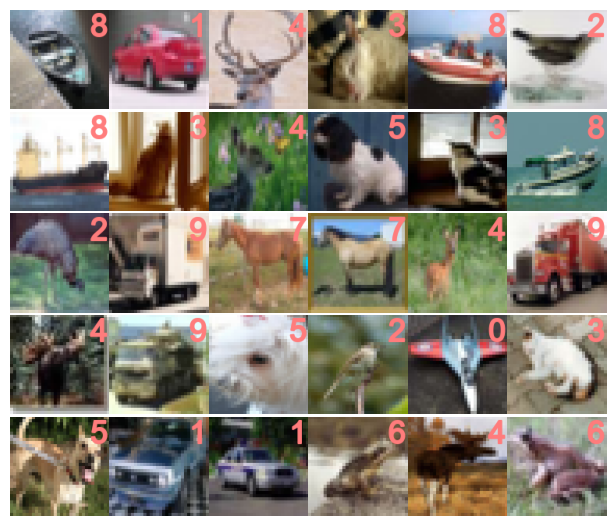

In [8]:
##### CIFAR10 #####

comparator.display_CIFAR10(5, 6, (7.7, 6.6))
plt.savefig("./CIFARDatasetFinal1Backup.png", dpi=1200, bbox_inches="tight")
plt.show()

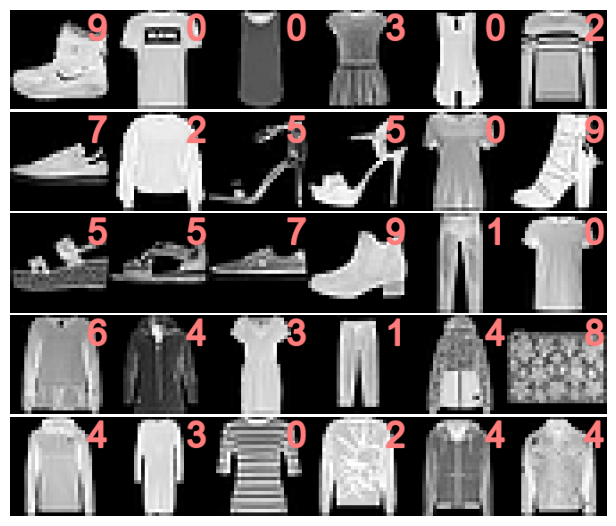

In [9]:
##### FASHION MNIST #####
# Load in FashionMNIST
comparator.load_fashionMNIST()
comparator.display_fashionMNIST(5, 6, (7.7, 6.6)) #4, 8, (7.7, 3.9)
plt.savefig("./FashionMNISTFinal1Backup.png", dpi=1200, bbox_inches="tight")
plt.show()

In [10]:
# Xavier | Tanh & ReLU
backprop_vals_tanh = comparator.run_fashionMNIST_backprop_test(torch.nn.Tanh, initialisation=XavierInitialisation)
backprop_vals_relu = comparator.run_fashionMNIST_backprop_test(torch.nn.ReLU, initialisation=XavierInitialisation)

# Const Var | Tanh & ReLU
backprop_vals_tanh_const_var = comparator.run_fashionMNIST_backprop_test(torch.nn.Tanh, initialisation=lambda params: ConstVarInitialisation(params, 1.592))#initialisation=ConstVarInitialisation)
backprop_vals_relu_const_var = comparator.run_fashionMNIST_backprop_test(torch.nn.ReLU, initialisation=lambda params: ConstVarInitialisation(params, 1.414))#initialisation=ConstVarInitialisation)

Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>


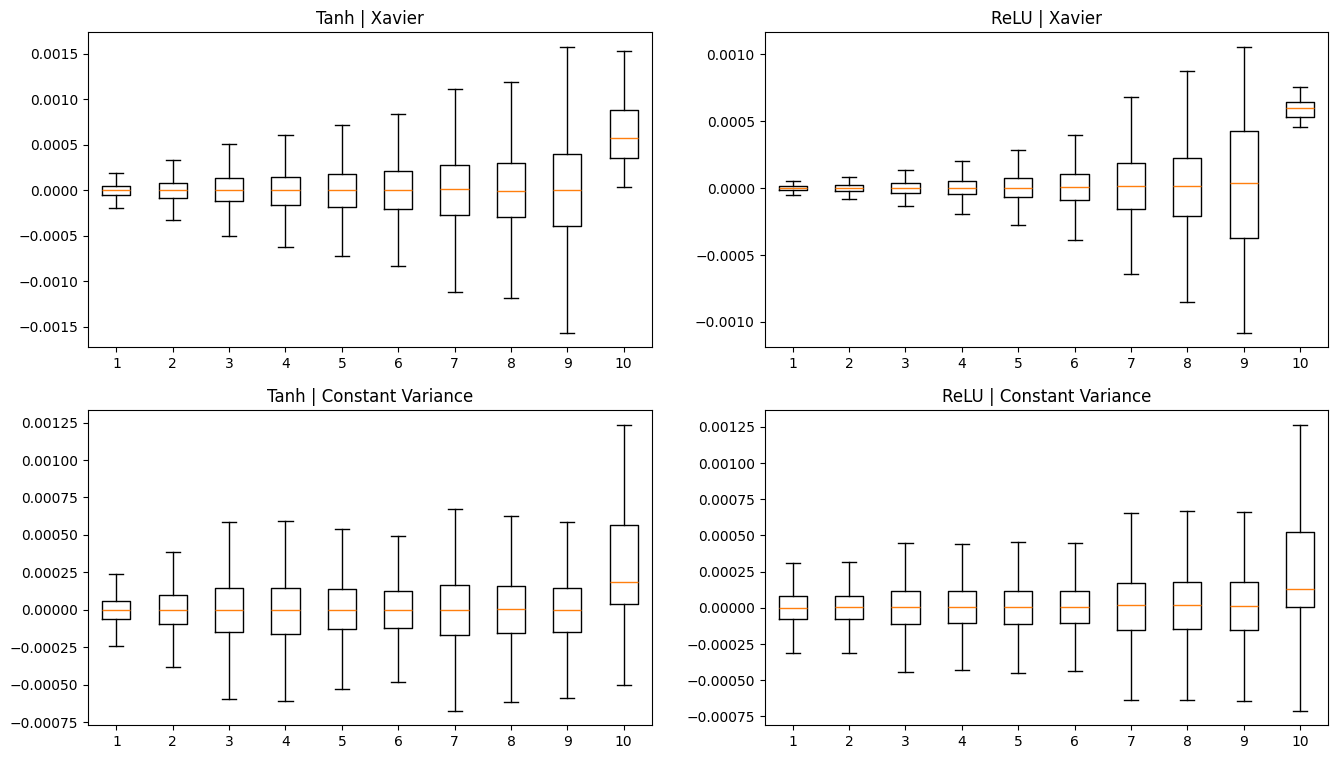

In [11]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9))

axes[0][0].boxplot([l[0].flatten() for l in list(backprop_vals_tanh.values())], showfliers=False)
relu_vals = [l[0].flatten() for l in list(backprop_vals_relu.values())]
axes[0][1].boxplot([r[r.nonzero()].flatten() for r in relu_vals], showfliers=False)
del relu_vals

axes[1][0].boxplot([l[0].flatten() for l in list(backprop_vals_tanh_const_var.values())], showfliers=False)
relu_vals = [l[0].flatten() for l in list(backprop_vals_relu_const_var.values())]
axes[1][1].boxplot([r[r.nonzero()].flatten() for r in relu_vals], showfliers=False)
del relu_vals

axes[0][0].set_title("Tanh | Xavier")
axes[0][1].set_title("ReLU | Xavier")

axes[1][0].set_title("Tanh | Constant Variance")
axes[1][1].set_title("ReLU | Constant Variance")

plt.show()

In [12]:
backprop_vals_tanh_layers = comparator.run_fashionMNIST_backprop_test_layers(torch.nn.Tanh, initialisation=XavierInitialisation, num_layers=30)
backprop_vals_relu_layers = comparator.run_fashionMNIST_backprop_test_layers(torch.nn.ReLU, initialisation=XavierInitialisation)

forward_prop_vals_tanh_layers = comparator.run_fashionMNIST_forward_prop_test_layers(torch.nn.Tanh, initialisation=XavierInitialisation)
forward_prop_vals_relu_layers = comparator.run_fashionMNIST_forward_prop_test_layers(torch.nn.ReLU, initialisation=XavierInitialisation)


backprop_vals_tanh_const_var_layers = comparator.run_fashionMNIST_backprop_test_layers(torch.nn.Tanh, initialisation=lambda params: ConstVarInitialisation(params, 1.592))
backprop_vals_relu_const_var_layers = comparator.run_fashionMNIST_backprop_test_layers(torch.nn.ReLU, initialisation=lambda params: ConstVarInitialisation(params, 1.414))
#lambda params: ConstVarInitialisation(params, 1.592)
#lambda params: ConstVarInitialisation(params, 1.414)

forward_prop_vals_tanh_const_var_layers = comparator.run_fashionMNIST_forward_prop_test_layers(torch.nn.Tanh, initialisation=lambda params: ConstVarInitialisation(params, 1.592))
forward_prop_vals_relu_const_var_layers = comparator.run_fashionMNIST_forward_prop_test_layers(torch.nn.ReLU, initialisation=lambda params: ConstVarInitialisation(params, 1.414))

Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.Tanh'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>
Using activation fun

In [13]:

def plot_layer_stds(values, ax, offset=0, c="tab:red"):

    medians = [torch.median(torch.tensor(values[i])) for i in range(len(values))]
    upper_quartiles = [torch.median(torch.tensor(values[i][values[i]>medians[i]])) for i in range(len(values))]
    lower_quartiles = [torch.median(torch.tensor(values[i][values[i]<=medians[i]])) for i in range(len(values))]

    maxs = [torch.max(torch.tensor(values[i])) for i in range(len(values))]
    mins = [torch.min(torch.tensor(values[i])) for i in range(len(values))]


    for i in range(len(upper_quartiles)):
        x_loc = i+offset
        p = Path([
            (x_loc, upper_quartiles[i]),
            (x_loc, lower_quartiles[i])
        ], codes=[Path.MOVETO, Path.LINETO])

        IQR = upper_quartiles[i] - lower_quartiles[i]
        p2 = Path([
            (x_loc, upper_quartiles[i] + 1.5*IQR),
            (x_loc, lower_quartiles[i] - 1.5*IQR)
        ], codes=[Path.MOVETO, Path.LINETO])

        p3 = Path([
            (x_loc, maxs[i]),
            (x_loc, mins[i])
        ], codes=[Path.MOVETO, Path.LINETO])

        ax.add_patch(PathPatch(p, lw=2, facecolor="orange", edgecolor=c, capstyle="round"))
        ax.add_patch(PathPatch(p2, lw=2, facecolor="orange", edgecolor=c, capstyle="round", alpha=0.3))

    ax.margins(0)
    ax.autoscale()

def plot_layer_std_mean(values, ax, offset=0, c="tab:red"):
    medians = [torch.mean(torch.tensor(values[i])) for i in range(len(values))]

    std_data = [torch.std(torch.tensor(values[i][values[i] != 0])) for i in range(len(values))]
    upper_quartiles = [medians[i]+std_data[i] for i in range(len(std_data))]

    lower_quartiles = [medians[i]-std_data[i] for i in range(len(std_data))]

    maxs = [torch.max(torch.tensor(values[i])) for i in range(len(values))]
    mins = [torch.min(torch.tensor(values[i])) for i in range(len(values))]


    for i in range(len(upper_quartiles)):
        x_loc = i+offset
        p = Path([
            (x_loc, upper_quartiles[i]),
            (x_loc, lower_quartiles[i])
        ], codes=[Path.MOVETO, Path.LINETO])

        ax.add_patch(PathPatch(p, lw=2, facecolor="orange", edgecolor=c, capstyle="round"))

    ax.margins(0)
    ax.autoscale()

In [14]:
tanh_xavier = [l[0].flatten() for l in list(backprop_vals_tanh_layers.values())]
relu_vals = [l[0].flatten() for l in list(backprop_vals_relu_layers.values())]
relu_xavier = [r[r.nonzero()].flatten() for r in relu_vals]
del relu_vals

tanh_he = [l[0].flatten() for l in list(backprop_vals_tanh_const_var_layers.values())]
relu_vals = [l[0].flatten() for l in list(backprop_vals_relu_const_var_layers.values())]
relu_he = [r[r.nonzero()].flatten() for r in relu_vals]
del relu_vals

C:\Users\rmen2\AppData\Local\Temp\ipykernel_2832\2233001466.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  medians = [torch.median(torch.tensor(values[i])) for i in range(len(values))]
C:\Users\rmen2\AppData\Local\Temp\ipykernel_2832\2233001466.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_quartiles = [torch.median(torch.tensor(values[i][values[i]>medians[i]])) for i in range(len(values))]
C:\Users\rmen2\AppData\Local\Temp\ipykernel_2832\2233001466.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lower_quartiles = [tor

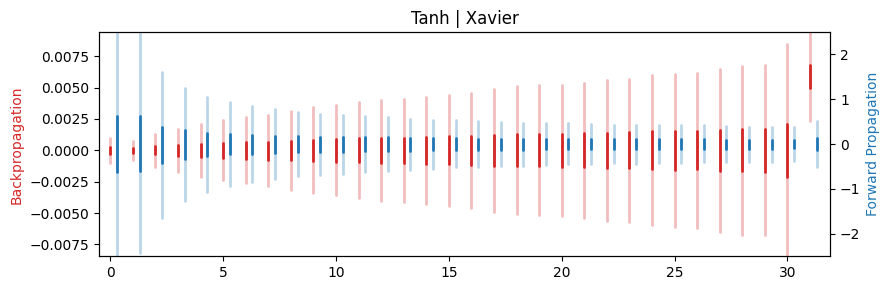

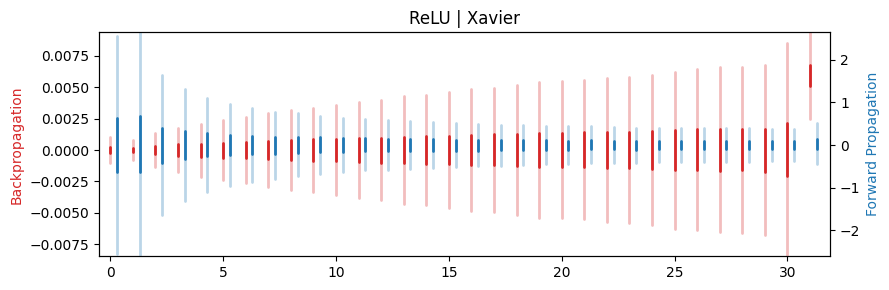

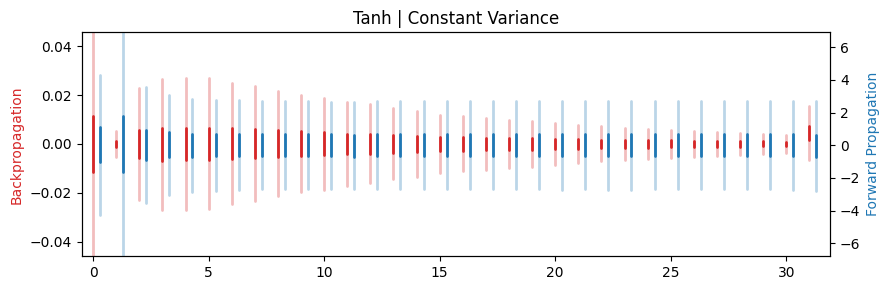

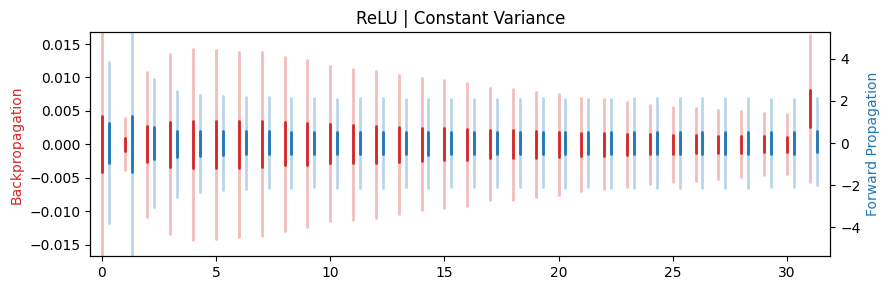

In [15]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("Tanh | Xavier")
ax.set_ylabel("Backpropagation", color="tab:red")
other_side_ax = ax.twinx()
other_side_ax.set_ylabel("Forward Propagation", color="tab:blue")
plot_layer_stds(list(forward_prop_vals_tanh_layers.values()), other_side_ax, offset = 0.3, c="tab:blue")
plot_layer_stds(tanh_xavier, ax)
plt.tight_layout()
ax.set_xlim(-0.5, 31.9)

plt.savefig("./TanhXavier2.png")
plt.show()

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("ReLU | Xavier")
ax.set_ylabel("Backpropagation", color="tab:red")
other_side_ax = ax.twinx()
other_side_ax.set_ylabel("Forward Propagation", color="tab:blue")
plot_layer_stds(list(forward_prop_vals_relu_layers.values()), other_side_ax, offset = 0.3, c="tab:blue")
plot_layer_stds(relu_xavier, ax)
plt.tight_layout()
ax.set_xlim(-0.5, 31.9)
plt.savefig("./ReLUXavier2.png")
plt.show()

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("Tanh | Constant Variance")
ax.set_ylabel("Backpropagation", color="tab:red")
other_side_ax = ax.twinx()
other_side_ax.set_ylabel("Forward Propagation", color="tab:blue")
plot_layer_stds(list(forward_prop_vals_tanh_const_var_layers.values()), other_side_ax, offset = 0.3, c="tab:blue")
plot_layer_stds(tanh_he, ax)
plt.tight_layout()
ax.set_xlim(-0.5, 31.9)
plt.savefig("./TanhHe2.png")
plt.show()

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("ReLU | Constant Variance")
ax.set_ylabel("Backpropagation", color="tab:red")
other_side_ax = ax.twinx()
other_side_ax.set_ylabel("Forward Propagation", color="tab:blue")
plot_layer_stds(list(forward_prop_vals_relu_const_var_layers.values()), other_side_ax, offset = 0.3, c="tab:blue")
plot_layer_stds(relu_he, ax)
plt.tight_layout()
ax.set_xlim(-0.5, 31.9)
plt.savefig("./ReLUHe2.png")
plt.show()

In [6]:

# 20 Layer Network almost identical to VGG-19, except padding was added to allow the input to reach the output
class NNCIFAR10(nn.Module):
    """
    Neural network for use with the CIFAR10 dataset.
    A 19 Layer Network almost identical to VGG-19, except padding was added to allow the input to reach the output.
    """
    def __init__(self, activation_function):
        super(NNCIFAR10, self).__init__()
        self.module_stack = nn.Sequential(
            # Input = layer 0
            nn.Conv2d(3, 64, (3, 3), padding=2), # 1
            activation_function(),
            nn.Conv2d(64, 64, (3, 3), padding=2), # 2
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, (3, 3), padding=2), # 3
            activation_function(),
            nn.Conv2d(128, 128, (3, 3), padding=2), # 4
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, (3, 3), padding=2), # 5
            activation_function(),
            nn.Conv2d(256, 256, (3, 3), padding=2), # 6
            activation_function(),
            nn.Conv2d(256, 256, (3, 3), padding=2), # 7
            activation_function(),
            nn.Conv2d(256, 256, (3, 3), padding=2), # 8
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(256, 512, (3, 3), padding=2), # 9
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=2), # 10
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=2), # 11
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=2), # 12
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(512, 512, (3, 3), padding=0), # 13
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=0), # 14
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Flatten(),
            #nn.BatchNorm1d(2048),

            nn.Linear(2048, 2048), # 15
            activation_function(),
            nn.Dropout(0.25),
            nn.Linear(2048, 2048), # 16
            activation_function(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024), # 17
            activation_function(),
            nn.Dropout(0.25),
            nn.Linear(1024, 10), # 18
        )

    def forward(self, x):
        return self.module_stack(x)

In [7]:
class Tanh8(nn.Module):
    """ Tanh8 activation function = Tanh(x*8)/8 """
    def __init__(self, inplace: bool = False):
        super(Tanh8, self).__init__()
        self.inplace = inplace
        self.tanh = nn.Tanh()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.tanh(input/8)*8

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [ ]:

##########################################################
#################### !WARNING! ###########################
########## !THIS CELL USES A LOT OF RAM! #################
############ !(ONLY RUN IT ON A GPU)! ####################
##########################################################

cifar_net = NNCIFAR10(nn.Tanh)
cifar_net_tan8 = NNCIFAR10(Tanh8)

cifar_net.eval()
ConstVarInitialisation(cifar_net, 1.4142)
forward_prop_unscaled = test_forward_propagation(
    cifar_net,
    comparator.cifar10_dataset,
    torch.nn.CrossEntropyLoss(),
)
#    activation = nn.Tanh()

XavierInitialisation(cifar_net)
forward_prop_xavier = test_forward_propagation(
    cifar_net,
    comparator.cifar10_dataset,
    torch.nn.CrossEntropyLoss(),
)
#    activation = nn.Tanh()

cifar_net_tan8.eval()
ConstVarInitialisation(cifar_net, 1.0153)
forward_prop_tan8 = test_forward_propagation(
    cifar_net_tan8,
    comparator.cifar10_dataset,
    torch.nn.CrossEntropyLoss(),
)
#    activation = nn.Tanh()

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("VGG19-CIFAR10 Forward Propagation")
ax.set_ylabel("Forward Propagation")
plot_layer_std_mean(list(forward_prop_unscaled.values()), ax, offset=0, c="tab:green")
plot_layer_std_mean(list(forward_prop_xavier.values()), ax, offset=0.2, c="tab:blue")
plot_layer_std_mean(list(forward_prop_tan8.values()), ax, offset=0.4, c="tab:red")

ax.set_xlim(-0.5, 35)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Layer")
ax.xaxis.set_minor_locator(MultipleLocator(1.0))
ax.xaxis.grid(True, which='both', color='k', linestyle='-', linewidth=1, alpha=0.1)
ax.yaxis.grid(True, which='major', color='k', linestyle='-', linewidth=1, alpha=0.1)

plt.tight_layout()
plt.savefig("./CIFAR10ForwardPropXavier7.png")

plt.show()